## Import

In [1]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../modules/')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import compose, pipeline, preprocessing, linear_model, model_selection, ensemble, feature_selection
import seaborn as sns
from tqdm import tqdm


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

## Data

### Load all data

In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()



### Join data, combine countries

In [3]:
country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)


## Experiments

### Common definitions

In [4]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2014"
T_TEST_MAX = "2014"

cv_default = model_selection.KFold(n_splits=8, shuffle=False)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

### Random Forest - possible feature combinations

In [17]:
### TRAINING
lags_default = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
alternate_lags_default = {
    "value": [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
}

model_names = [
    "bench-rw",
    "bench-rw-realistic",
    "19",
    "ar",
    "ar+19",
]

feature_combinations = [
    ["value"],
    ["value"],
    ["19"],
    ["value"],
    ["value", "19"],
]

lags = [
    [1],
    [5],
    lags_default,
    lags_default,
    lags_default,
]

alternate_lags = [
    {},
    {},
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
]

use_linear_dummy = [True, True, False, False, False]

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8, 16],
    "randomforestregressor__min_samples_split": [2, 4, 8],
}

for i, name in enumerate(tqdm(model_names)):

    labeled = eumf_pipeline.prepare_data(
        panel_comb,
        columns=feature_combinations[i],
        lags=lags[i],
        alternate_lags=alternate_lags[i],
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled, delta=12)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    if use_linear_dummy[i]:
        tuner = None
        estimator = eumf_custom_models.make_linear_dummy_model(
            train_stacked, features=[feature_combinations[i][0] + "_" + str(lags[i][0])]
        )
    else:
        tuner = eumf_pipeline.train_reg_model(
            train_stacked,
            reg=ensemble.RandomForestRegressor(random_state=42),
            extra_pipeline_steps=[preprocessing.StandardScaler()],
            params=params,
            scoring=eumf_eval.scorer_rmse,
        )
        estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(estimator, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(estimator, test_stacked,)
    test_scores.append(test_score)


100%|██████████| 5/5 [07:42<00:00, 92.44s/it] 


In [18]:
pd.DataFrame(
    {
        k: t.best_params_
        for k, t in zip(model_names, tuners)
        if t is not None
    }
).transpose()



,randomforestregressor__max_features,randomforestregressor__min_impurity_decrease,randomforestregressor__min_samples_leaf,randomforestregressor__min_samples_split
19,auto,0.0,1,2
ar,auto,0.0,16,2
ar+19,auto,0.0,2,2


In [20]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                   score_time                   test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                     mean    std      sem        mean     std      sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
bench-rw             0.006   0.001  4.241e-04    0.011    0.004  1.320e-03  -0.107   0.015  0.005   -0.143   0.024  0.009           0.021          0.392  0.139     0.145    0.471  0.167      0.030      0.062  0.022
bench-rw-realistic   0.009   0.006  2.015e-03    0.011    0.004  1.516e-03  -0.127   0.030  0.011   -0.172   0.046  0.016          -0.251          0.311  0.110    -0.085    0.441  0.156      0.011      0.051  0.018
19                   1.973   0.282  9.974e-02    0.021    0.014  4.810e-03  -0.108   0.029  0.010   -0.152   0.047  0.017           0.072          0.220  0.078     0.177    0.330  0.117      0.029      0.045  0.016
ar                   0.724   0.074  2.626e-02    0.013    0.002  5.963e-04  -0.107   0.037  0.013   -0.150   0.055  0.019           0.183          0.103  0.036     0.260    0.206  0.073      0.030      0.039  0.014
ar+19                2.338   0.086  3.038e-02    0.014    0.002  7.156e-04  -0.098   0.027  0.010   -0.137   0.043  0.015           0.255          0.143  0.051     0.341    0.233  0.082      0.039      0.047  0.017

In [8]:
eumf_eval.agg_multiple_test_scores(test_scores, model_names).sort_values("rmse", ascending=False)

,mae,rmse,explained_variance,r2_mod,delta_mae
bench-rw,-0.121,-0.159,0.570,0.614,0.042
ar+19,-0.118,-0.170,0.513,0.559,0.046
ar,-0.120,-0.179,0.456,0.511,0.043
19,-0.136,-0.205,0.339,0.360,0.027
bench-rw-realistic,-0.154,-0.219,0.211,0.271,0.010


#### Performance by year (CV+test)

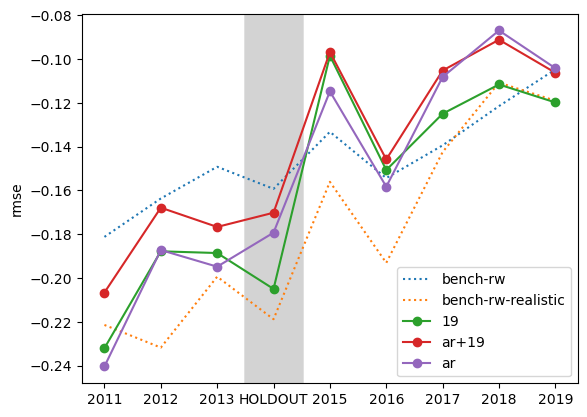

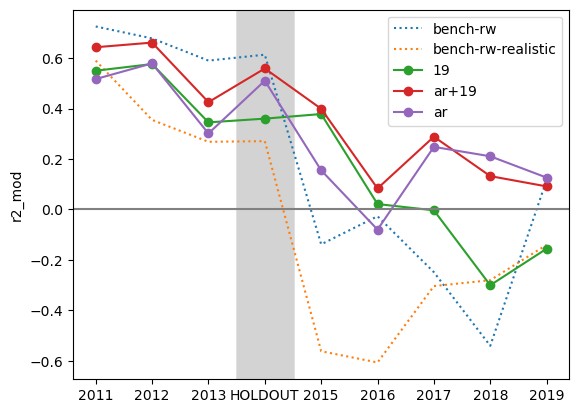

In [9]:
comp_models = ["bench-rw", "bench-rw-realistic", "19", "ar+19", "ar"]

indices = [model_names.index(name) for name in comp_models]
benchmark_indices = [0, 1]
metrics = ["rmse", "r2_mod"]

fold_labels = [2011, 2012, 2013, "HOLDOUT", 2015, 2016, 2017, 2018, 2019]

for m in metrics:
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=model_names,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=fold_labels.index("HOLDOUT"),
        benchmark_indices=benchmark_indices,
    )
    if m=="r2_mod":
        plt.axhline(0.0, c="grey")
    plt.show()

#### Performance by country

##### prepare dummy scores (realistic)

In [10]:
test_scores_c_dummy = eumf_eval.score_test_countries(estimators[1], test_stackeds[1])
cv_scores_c_dummy = eumf_eval.score_cv_countries(estimators[1], train_unstackeds[1], cv_default)

##### best model without AR lags

test scores

In [11]:
i = model_names.index("19")


In [12]:

test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse_vs_dummy"] = test_scores_c["rmse"] - test_scores_c_dummy["rmse"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae,rmse_vs_dummy
IT,-0.056,-0.069,0.485,0.897,1.492e-01,0.034
GR,-0.047,-0.054,0.141,0.714,3.839e-02,0.049
HR,-0.464,-0.591,0.014,0.491,2.261e-01,0.029
CZ+SK,-0.067,-0.083,0.170,0.451,2.087e-02,0.038
AT+CH,-0.059,-0.071,0.039,0.354,1.765e-02,0.039
PT,-0.166,-0.204,-0.018,0.298,3.539e-02,0.071
RO,-0.303,-0.320,0.069,0.255,5.202e-02,-0.100
SE+FI+DK,-0.104,-0.118,0.132,0.154,1.122e-02,0.060
BE+NL+LU,-0.080,-0.105,-0.152,0.117,1.183e-03,0.038
BG,-0.277,-0.292,0.075,0.004,-5.539e-04,-0.045


CV scores

In [13]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse_vs_dummy"] = cv_scores_c["rmse"] - cv_scores_c_dummy["rmse"]
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0)
display(cv_scores_c_agg.sort_values(by=("rmse", 0.5), ascending=False))


CV scores per country:


KeyError: ('rmse', 0.5)

plot RMSE absolute

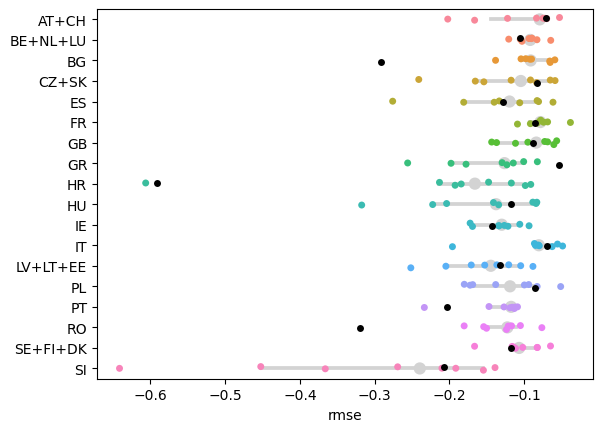

In [ ]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
    estimator=np.median
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot RMSE vs dummy

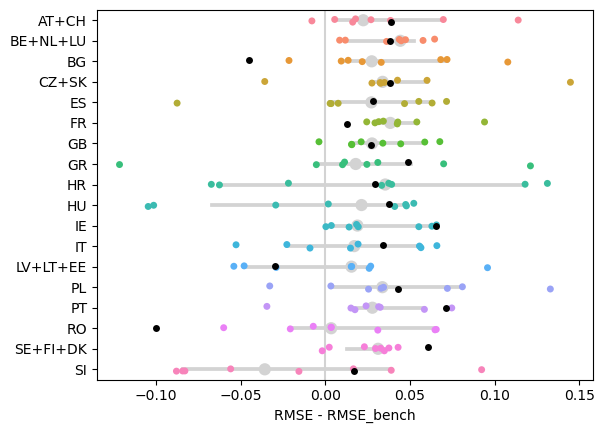

In [ ]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse_vs_dummy",
    linestyles="",
    color="lightgrey",
    estimator=np.median
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse_vs_dummy")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse_vs_dummy", color="k")
plt.axvline(0.0, c="lightgrey")
plt.xlabel("RMSE - RMSE_bench")
plt.ylabel("")
plt.show()


plot R2

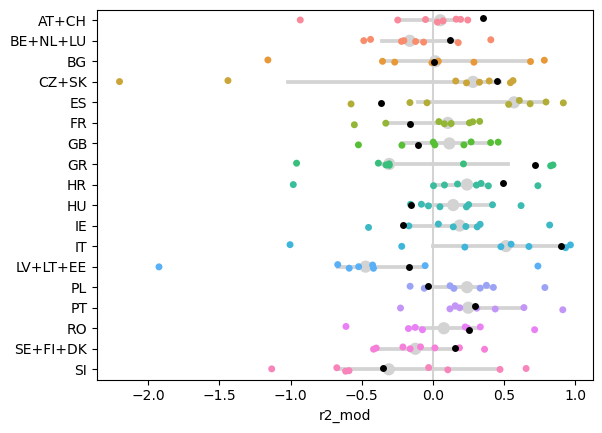

In [ ]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="r2_mod",
    linestyles="",
    color="lightgrey",
    estimator=np.median,
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="r2_mod")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="r2_mod", color="k")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.show()


##### best model with AR lags: value + KW19

test scores

In [ ]:
i = model_names.index("ar+19")


In [ ]:

test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse_vs_dummy"] = test_scores_c["rmse"] - test_scores_c_dummy["rmse"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,rmse_vs_dummy
IT,-0.031,-0.039,0.712,0.968,0.064
HR,-0.378,-0.431,0.250,0.729,0.188
LV+LT+EE,-0.061,-0.080,-0.358,0.580,0.024
AT+CH,-0.052,-0.061,0.339,0.526,0.049
CZ+SK,-0.068,-0.078,0.220,0.520,0.044
RO,-0.243,-0.271,-0.292,0.465,-0.051
GR,-0.065,-0.081,-0.370,0.362,0.022
BG,-0.226,-0.243,0.114,0.309,0.004
PT,-0.156,-0.207,-0.300,0.276,0.068
GB,-0.062,-0.073,0.153,0.232,0.042


CV scores

In [ ]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse_vs_dummy"] = cv_scores_c["rmse"] - cv_scores_c_dummy["rmse"]
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0)
display(cv_scores_c_agg.sort_values(by=("rmse", 0.5), ascending=False))


CV scores per country:


mae                  rmse                explained_variance                   r2_mod               rmse_vs_dummy              
          0.25   0.50   0.75   0.25   0.50   0.75         0.25           0.50     0.75   0.25   0.50   0.75       0.25      0.50   0.75 
IT       -0.067 -0.049 -0.041 -0.084 -0.066 -0.063       -0.106        2.697e-01  0.387  0.320  0.433  0.643      0.005     0.026  0.042
AT+CH    -0.074 -0.059 -0.053 -0.109 -0.070 -0.067       -0.059        3.797e-02  0.087 -0.035  0.099  0.182      0.024     0.038  0.050
FR       -0.067 -0.062 -0.059 -0.094 -0.076 -0.068       -0.158       -4.928e-03  0.106 -0.222  0.054  0.232      0.039     0.041  0.045
BG       -0.084 -0.067 -0.059 -0.105 -0.083 -0.069       -0.373       -1.001e-01  0.011 -0.221 -0.058  0.191      0.017     0.036  0.056
GB       -0.085 -0.070 -0.053 -0.109 -0.084 -0.066       -0.101       -2.779e-02  0.082  0.077  0.168  0.308      0.026     0.031  0.041
CZ+SK    -0.126 -0.066 -0.059 -0.151 -0.084 -0.074        0.038        2.165e-01  0.388 -0.010  0.256  0.439      0.039     0.046  0.053
BE+NL+LU -0.081 -0.068 -0.058 -0.104 -0.092 -0.075       -0.209       -7.731e-02 -0.008 -0.170 -0.097  0.179      0.025     0.044  0.058
PL       -0.137 -0.086 -0.065 -0.180 -0.100 -0.086        0.054        1.456e-01  0.290  0.231  0.292  0.360      0.024     0.034  0.060
SE+FI+DK -0.092 -0.078 -0.062 -0.116 -0.104 -0.075       -0.106        1.401e-02  0.100 -0.107  0.112  0.247      0.029     0.032  0.040
RO       -0.106 -0.088 -0.069 -0.124 -0.105 -0.093       -0.377       -7.696e-02  0.173  0.031  0.317  0.597      0.007     0.033  0.049
HU       -0.138 -0.091 -0.079 -0.160 -0.111 -0.093       -0.279        5.657e-02  0.078  0.363  0.410  0.504     -0.003     0.027  0.045
ES       -0.123 -0.091 -0.069 -0.152 -0.115 -0.087       -0.358       -8.290e-02  0.197  0.309  0.631  0.774      0.017     0.032  0.045
PT       -0.108 -0.092 -0.082 -0.136 -0.117 -0.100       -0.116       -1.148e-02  0.101  0.161  0.497  0.672      0.032     0.041  0.049
LV+LT+EE -0.122 -0.093 -0.085 -0.143 -0.121 -0.103       -0.199        6.344e-04  0.245 -0.614  0.088  0.213      0.007     0.028  0.050
GR       -0.134 -0.107 -0.082 -0.165 -0.131 -0.101       -0.178        5.606e-02  0.248 -0.470  0.089  0.477      0.019     0.025  0.047
IE       -0.123 -0.110 -0.095 -0.150 -0.135 -0.125       -0.763       -7.325e-02  0.008 -0.061 -0.011  0.076      0.012     0.025  0.038
HR       -0.154 -0.135 -0.091 -0.172 -0.153 -0.127        0.057        1.637e-01  0.381  0.100  0.227  0.424     -0.021     0.029  0.066
SI       -0.237 -0.129 -0.111 -0.284 -0.164 -0.144       -0.250       -1.106e-01  0.077  0.099  0.301  0.522      0.016     0.042  0.075

plot RMSE absolute

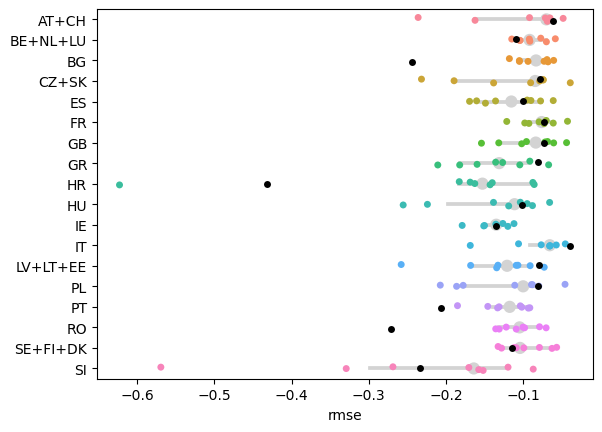

In [ ]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
    estimator=np.median
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot RMSE vs dummy

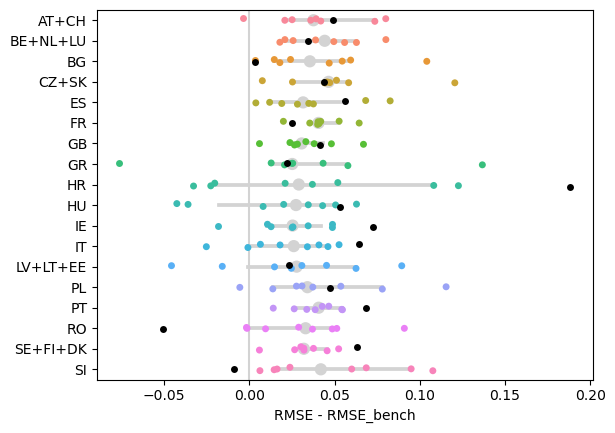

In [ ]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse_vs_dummy",
    linestyles="",
    color="lightgrey",
    estimator=np.median
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse_vs_dummy")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse_vs_dummy", color="k")
plt.axvline(0.0, c="lightgrey")
plt.xlabel("RMSE - RMSE_bench")
plt.ylabel("")
plt.show()


plot R2

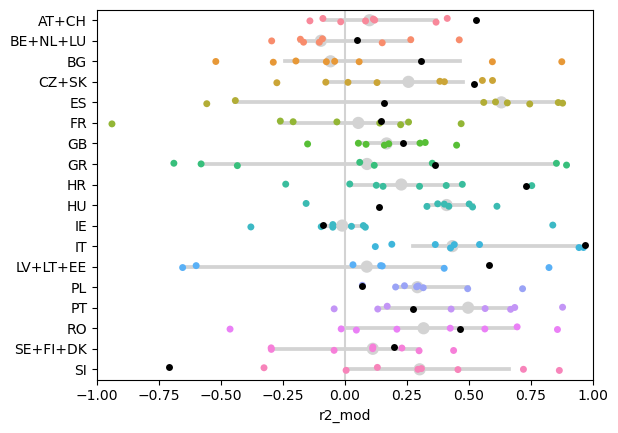

In [ ]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="r2_mod",
    linestyles="",
    color="lightgrey",
    estimator=np.median,
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="r2_mod")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="r2_mod", color="k")
plt.axvline(0.0, c="lightgrey")
plt.xlim(-1, 1)
plt.ylabel("")
plt.show()


#### How important is Google Trends for each country? (diff KW19 vs no KW19)


##### with own lags

In [ ]:
i1 = model_names.index("ar+19")
i2 = model_names.index("ar")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0)

cv_diff_agg["rmse"]

,0.25,0.50,0.75
AT+CH,-1.273e-03,4.636e-03,0.011
BE+NL+LU,-1.560e-03,4.048e-03,0.006
BG,-3.175e-03,2.158e-03,0.017
CZ+SK,-5.795e-04,7.652e-03,0.028
ES,7.515e-03,1.281e-02,0.017
FR,-1.379e-03,2.655e-03,0.008
GB,2.694e-03,4.849e-03,0.011
GR,2.346e-03,9.897e-03,0.054
HR,-6.826e-03,1.706e-02,0.047
HU,-1.265e-02,-5.283e-03,0.005


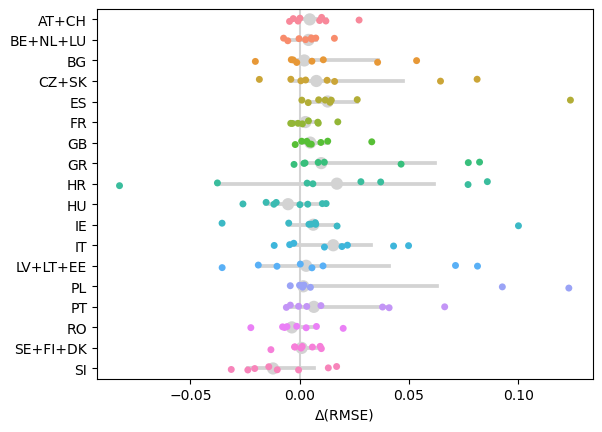

In [ ]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
    estimator=np.median,
)
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="rmse")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(RMSE)")
plt.show()


#### feature importance

In [ ]:
i = model_names.index("19")
reg = tuners[i].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)

19_1                1.741e-01
19_4                8.284e-02
19_2                7.069e-02
19_3                7.002e-02
19_6                5.017e-02
19_11               4.923e-02
19_13               4.707e-02
19_14               4.603e-02
19_8                4.464e-02
19_10               4.068e-02
19_17               3.908e-02
19_15               3.901e-02
19_16               3.807e-02
19_9                3.608e-02
19_12               3.355e-02
19_7                3.216e-02
19_18               3.077e-02
19_5                2.895e-02
country_GR          8.051e-03
country_RO          6.746e-03
country_HR          6.331e-03
country_SI          4.341e-03
country_ES          4.233e-03
country_PL          2.957e-03
country_AT+CH       2.398e-03
country_HU          2.396e-03
country_IT          2.160e-03
country_PT          1.565e-03
country_GB          1.101e-03
country_CZ+SK       9.388e-04
country_LV+LT+EE    9.362e-04
country_IE          7.848e-04
country_BG          6.362e-04
country_BE

In [ ]:
i = model_names.index("ar+19")
reg = tuners[i].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)

value_5             2.095e-01
value_6             2.003e-01
19_1                7.829e-02
19_4                4.014e-02
19_2                3.410e-02
19_3                3.107e-02
value_7             3.021e-02
value_12            2.937e-02
19_12               2.559e-02
19_11               2.343e-02
19_14               1.741e-02
19_15               1.654e-02
19_6                1.615e-02
value_9             1.594e-02
value_11            1.524e-02
19_13               1.486e-02
19_9                1.453e-02
value_13            1.377e-02
19_8                1.377e-02
19_7                1.309e-02
19_5                1.307e-02
value_8             1.252e-02
19_16               1.237e-02
19_18               1.208e-02
19_17               1.201e-02
19_10               1.191e-02
value_17            1.181e-02
value_10            1.056e-02
value_18            9.704e-03
value_14            9.066e-03
value_15            8.977e-03
value_16            7.873e-03
country_GR          3.090e-03
country_HR

#### Plot prediction

##### with own lags

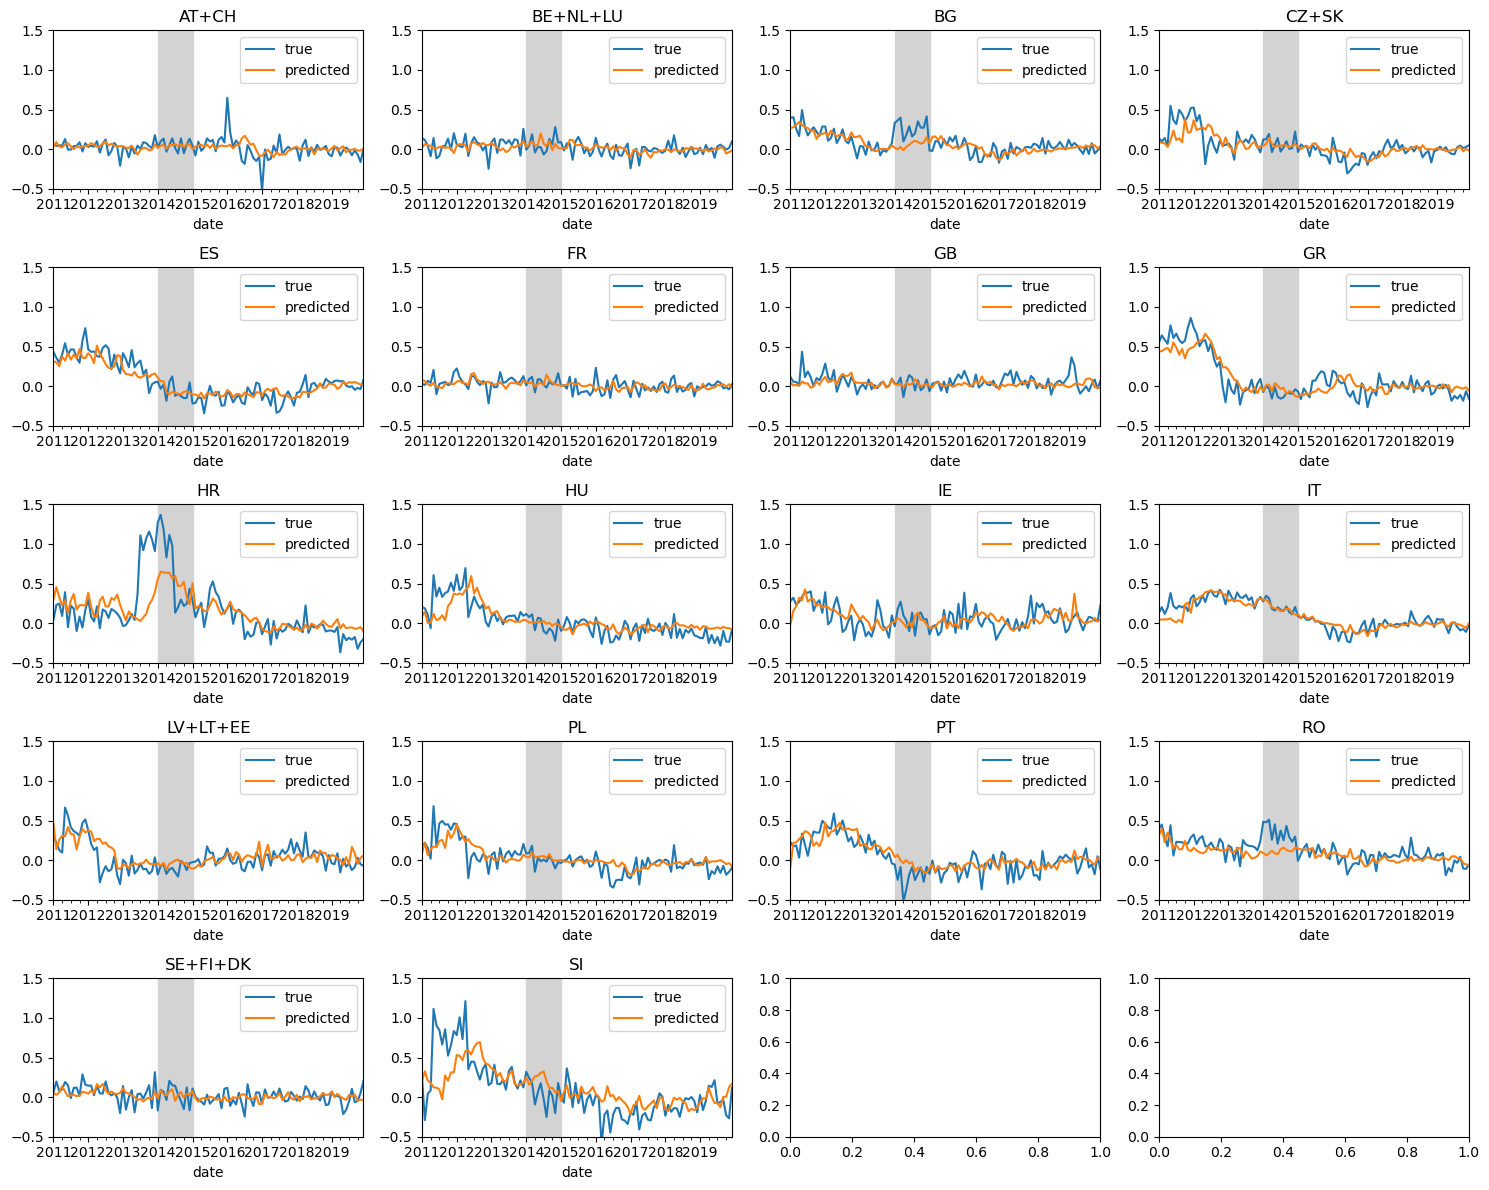

In [ ]:
i = model_names.index("ar+19")
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()


#### Without own lags

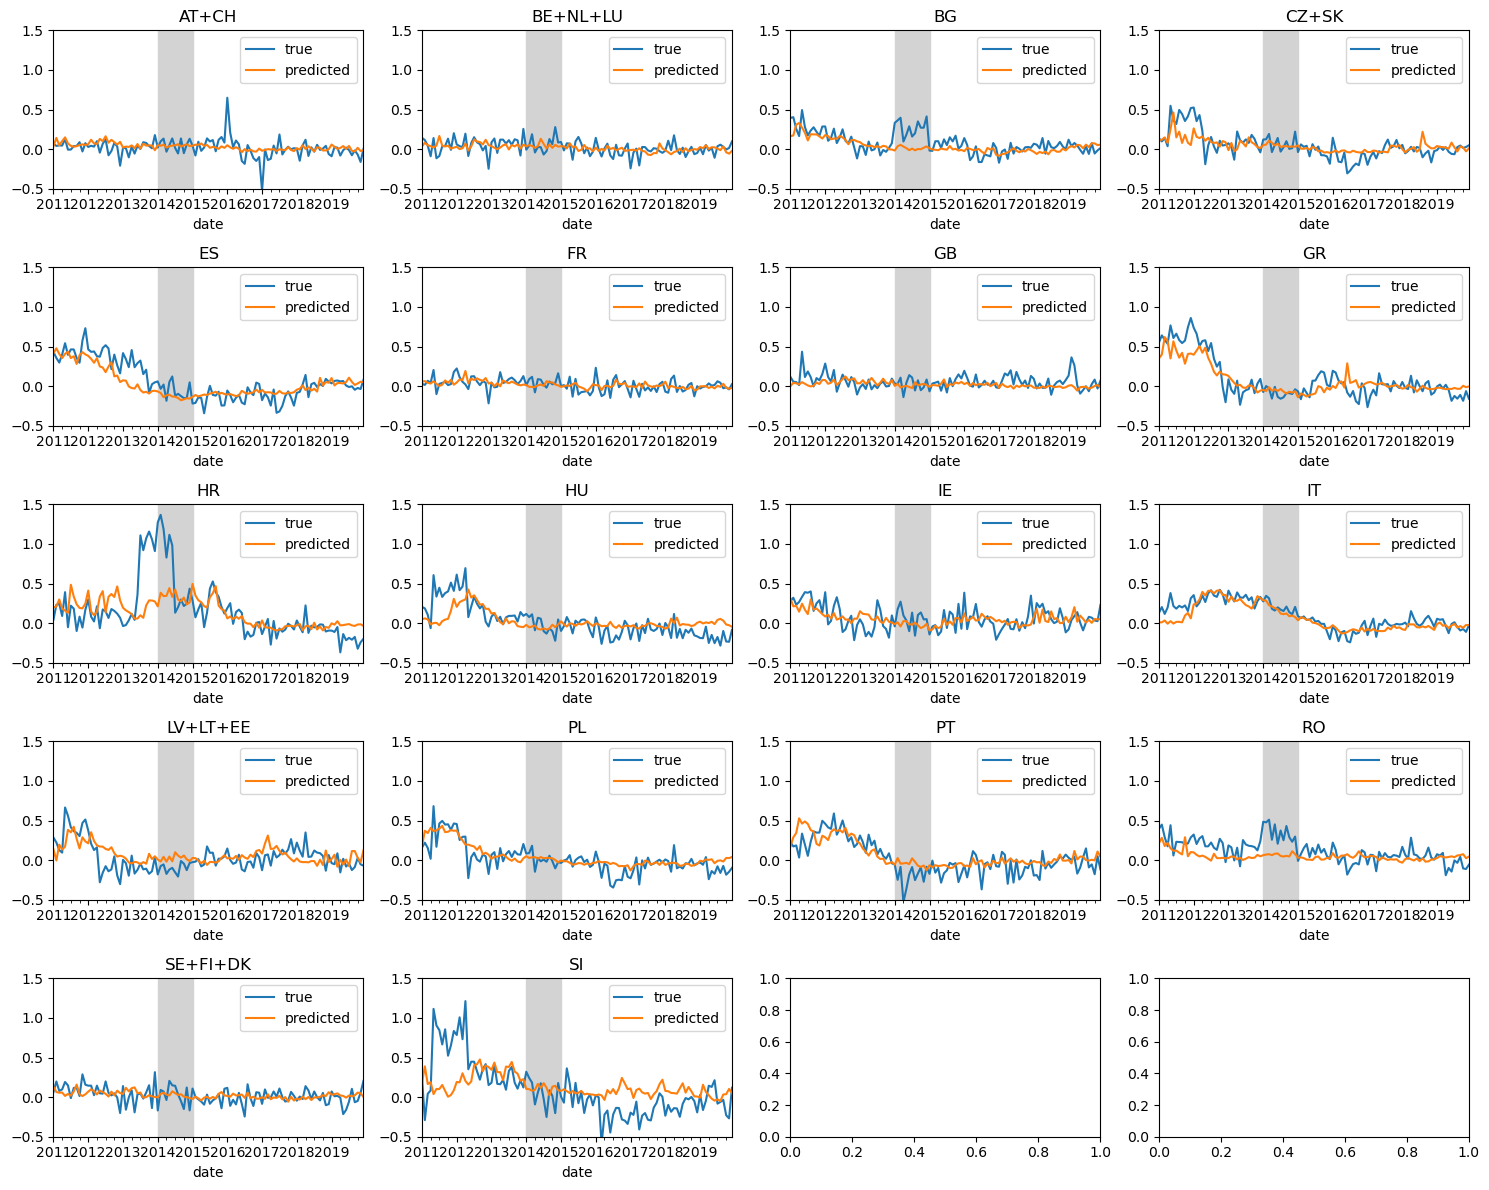

In [ ]:
i = model_names.index("19")

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()